In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as stats
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
import os
os.path

In [8]:
def data_deal():
    data = pd.read_csv('~data.csv', index_col=0)
    '''#这个是转换btc数据符合每日闭市时间用的
    btc_data = pd.read_csv('btc_data.csv', index_col=0)

    # 为了区分冬时令和夏时令，冬时令5：00休市，夏时令4:00休市，美国时间比我们晚，所以
    btc_data1 = btc_data[:"2020/3/2 23:59"]
    btc_data1 = btc_data1[[i % 1440 == 0 for i in range(len(btc_data1.index))]]

    btc_data2 = btc_data["2020/3/3 4:00":"2020/10/31 23:59"]
    btc_data2 = btc_data2[[i % 1440 == 0 for i in range(len(btc_data2.index))]]

    btc_data3 = btc_data["2021/3/14 5:00":"2021/3/14 23:59"]
    btc_data3 = btc_data3[[i % 1440 == 0 for i in range(len(btc_data3.index))]]

    btc_data4 = btc_data["2021/3/15 4:00":"2021/11/6 5:00"]
    btc_data4 = btc_data4[[i % 1440 == 0 for i in range(len(btc_data4.index))]]

    btc_data5 = btc_data["2021/11/7 5:00":]
    btc_data5 = btc_data5[[i % 1440 == 0 for i in range(len(btc_data5.index))]]
    # 最终得到和gbtc close价格时间相对应的数据
    btc_data_close = pd.concat([btc_data1, btc_data2, btc_data3, btc_data4, btc_data5])
'''
    gbtc_data = data.loc[:"2019/12/31", ["Holdings/Share", "Market Price/Share"]]

    # 线性填充GBTC数据
    date_index = pd.date_range('2019/12/31', '2022/2/8')
    gbtc_data.index = pd.to_datetime(gbtc_data.index)

    gbtc_data_filled = gbtc_data.reindex(date_index)
    gbtc_data_filled = gbtc_data_filled.interpolate(method='linear')

    gbtc_data_filled.to_csv("~gbtc_data_filled.csv")
    #btc_data_close.to_csv("~btc_data_close.csv")

data_deal()

In [12]:
#读取数据
gbtc_data_filled = pd.read_csv('~gbtc_data_filled.csv' , index_col=0)
#算出溢价率
gbtc_data_filled['discount rate']=(gbtc_data_filled['Market Price/Share']-gbtc_data_filled['Holdings/Share'])/gbtc_data_filled['Holdings/Share']
gbtc_data_filled

,Holdings/Share,Market Price/Share,discount rate
2019-12-31,6.980000,8.190000,0.173352
2020-01-01,6.905000,8.085000,0.170891
2020-01-02,6.830000,7.980000,0.168375
2020-01-03,6.990000,8.560000,0.224607
2020-01-04,7.083333,8.706667,0.229176
...,...,...,...
2022-02-04,37.740000,27.960000,-0.259141
2022-02-05,38.843333,28.826667,-0.257874
2022-02-06,39.946667,29.693333,-0.256676
2022-02-07,41.050000,30.560000,-0.255542


In [14]:
# 区分训练集和测试集7：3
train_end = int(len(gbtc_data_filled) / 10 * 7)
train = gbtc_data_filled['discount rate'][:train_end]
test = gbtc_data_filled['discount rate'][train_end:]
test=pd.DataFrame(test)
train

2019-12-31    0.173352
2020-01-01    0.170891
2020-01-02    0.168375
2020-01-03    0.224607
2020-01-04    0.229176
                ...   
2021-06-17   -0.139080
2021-06-18   -0.144416
2021-06-19   -0.134873
2021-06-20   -0.124628
2021-06-21   -0.113600
Name: discount rate, Length: 539, dtype: float64

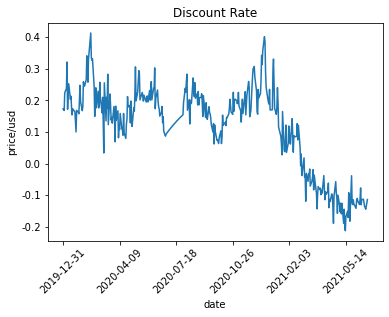

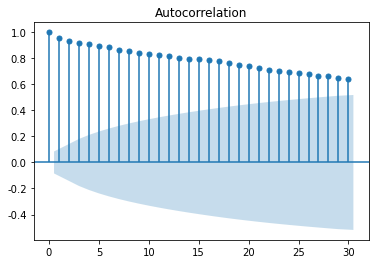

(-1.4199778975762218, 0.5726618790297056, 3, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, -1996.8493738337693)


In [18]:
#对原始数据进行图像描述以及自相关性检验
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
train.plot()
plt.title("Discount Rate")  # 添加图标题
plt.xticks(rotation=45)  # 横坐标旋转45度
plt.xlabel('date')  # 添加图的标签（x轴，y轴）
plt.ylabel('price/usd')

from statsmodels.graphics.tsaplots import plot_acf  # 导入自相关函数

plot_acf(train, use_vlines=True, lags=30)  # "lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据自相关图
plt.show()

#ADF检验结果
result = sm.tsa.stattools.adfuller(train)
print(result)

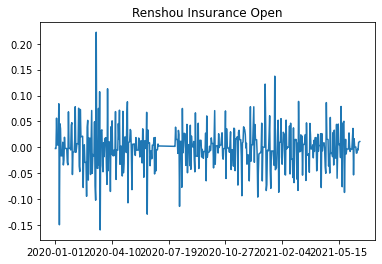

(-18.445438818528405, 2.1578438913680708e-30, 2, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, -1992.1260841393087)


In [19]:
# 进行差分再次检验
train_d1 = train.diff(1).dropna()
train_d1.columns = [u'train_diff1']
train_d1.plot()  # 绘制出差分后的时序图
plt.title("Renshou Insurance Open")  # 添加图标题
plt.show()  # 展示差分后的时序图
result = sm.tsa.stattools.adfuller(train_d1)
print(result)
# 拒绝原假设，一阶差分之后，时间序列平稳

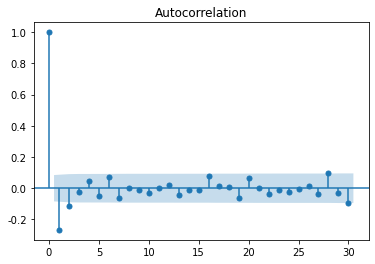

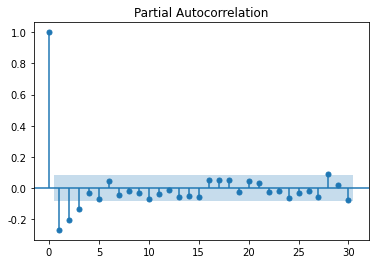

In [20]:
# 绘制差分后自相关图与偏自相关图
from statsmodels.graphics.tsaplots import plot_acf  # 导入自相关函数
plot_acf(train_d1, use_vlines=True, lags=30)
plt.show()

from statsmodels.graphics.tsaplots import plot_pacf  # 导入偏自相关函数
plot_pacf(train_d1, use_vlines=True, lags=30)
plt.show()


In [ ]:
# 对差分后数据进行白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox  # 对差分后达到平稳的数据进行白噪声检验

LjungBox = acorr_ljungbox(train_d1, lags=1)
print(LjungBox)# 发现序列是非白噪声序列

In [ ]:
def evaluate():
    #建模并进行模型评价
    from statsmodels.tsa.arima.model import ARIMA
    # 这里我是通过pac和pacf图的拖尾来确定阶数
    model = ARIMA(train, order=(1, 1, 1))
    result = model.fit()
    result.summary()
    result.conf_int()
    resid = result.resid
    import scipy.stats as stats
    sm.ProbPlot(resid,stats.t,fit=True).qqplot(line='45')
    plt.show()
    #qqplot 基本在红线上，认为残差服从正态分布
evaluate()

In [25]:
import numba
from numba import jit

#寻找阶数
#@jit
def find_piq(data=train):
    i = 0
    while True:
        train_di = train.diff(i).dropna()
        result = sm.tsa.stattools.adfuller(train_di)
        if result[1] <= 0.01:
            break
        else:
            i = i + 1


    P=[0,1,2,3,4,5]
    Q=[0,1,2,3,4,5]
    BIC=10000000000
    f_p=0
    f_q=0
    for p in P:
        for q in Q:
            model = ARIMA(data,order=(p,i,q))
            result=model.fit()
            if result.bic <BIC:
                BIC=result.bic
                f_p=p
                f_q=q

    return(f_p,i,f_q)

In [28]:
#预测函数
#@jit
def arima_model(data=train):

    model = ARIMA(data, order=(1,1,1))#真实应用中换成find_piq(data)
    result = model.fit()
    result.summary()
    result.conf_int()  # 系数显著
    forcast=result.forecast(1) #需要在这里改预测长度
    return forcast

In [29]:
def draw(forcast_result,test):
    #画出图像进行比较
    date_index=pd.date_range('2021/6/22','2022/2/8')
    forcast_result = forcast_result.set_index(date_index)
    test=test.set_index(pd.date_range('2021/6/22','2022/2/8'))
    forcast_result.columns=['forcast_1']
    test.columns=['test']
    show_result=forcast_result.join(test[0:])
    show_result.plot()
    plt.title("Discount Rate")  # 添加图标题
    plt.xticks(rotation=45)  # 横坐标旋转45度
    plt.xlabel('date')  # 添加图的标签（x轴，y轴）
    plt.ylabel('%')
    plt.show()

In [ ]:
#预测结果分析
forcast_result=pd.DataFrame()
for i in range(232):
    data=gbtc_data_filled['discount rate'][i:539 + i]
    q=arima_model(data)
    q=pd.DataFrame(q)       #这个是为了多步预测的时候取最后一个数弄的
    forcast_result=forcast_result.append(pd.DataFrame(q[0:1]),ignore_index=True)
forcast_result


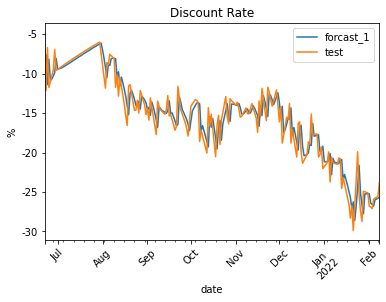

In [32]:
draw(forcast_result*100,test*100)

In [33]:
def average_abs_error():
    r1=test['discount rate'][0:].tolist()
    r2=forcast_result[0].tolist()
    r=list(map(lambda x: abs(x[0]-x[1]),zip(r1,r2)))
    average_abs_error=np.average(r)
    print(np.average(r))
    return average_abs_error

average_abs_error()

0.012494000403887614


0.012494000403887614